In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


2025-11-23 20:32:02.025205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 20:32:02.552040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 20:32:04.238255: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_csv("/home/aventior_sant/Downloads/Kaiser_task/HAM10000_metadata.csv")
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


### EDA

In [4]:
size = df.shape
size

(10015, 7)

In [5]:
null = df.isnull().sum()
null

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [6]:
unique_values_dx = df['dx'].unique()
print(unique_values_dx)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [7]:
unique_values_dx_type = df['dx_type'].unique()
print(unique_values_dx_type)

['histo' 'consensus' 'confocal' 'follow_up']


In [8]:
unique_values_age = df['age'].unique()
print(unique_values_age)

[80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.
 15.]


In [9]:
unique_values_sex = df['sex'].unique()
print(unique_values_sex)

['male' 'female' 'unknown']


In [10]:
unique_values_localization = df['localization'].unique()
print(unique_values_localization)

['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [11]:
df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0032258,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


### Class distribution (dx = diagnosis)¶

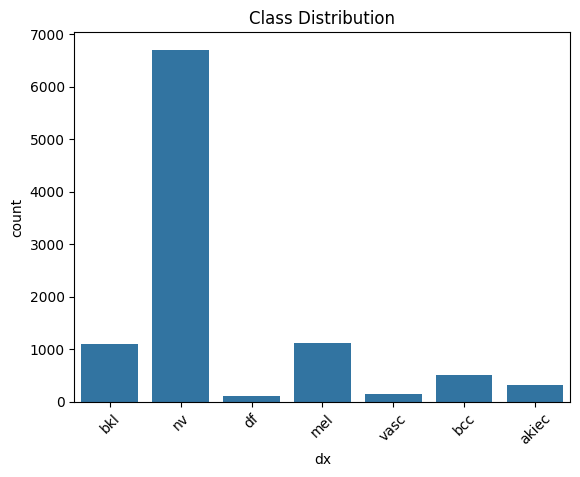

In [12]:
import seaborn as sns

sns.countplot(data=df, x="dx")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


### Sex distribution

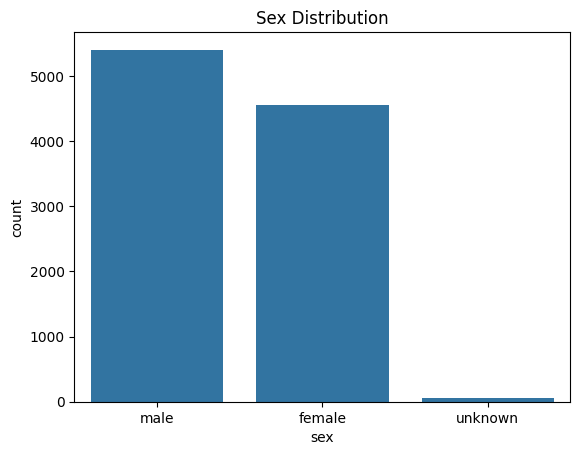

In [13]:
sns.countplot(data=df, x="sex")
plt.title("Sex Distribution")
plt.show()


### Age distribution

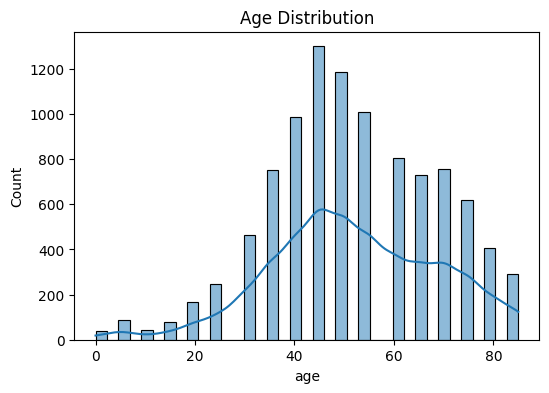

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()


### Clean the data

In [15]:
df["age"].fillna(df["age"].mean(), inplace=True)


/tmp/ipykernel_565484/1416930595.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"].fillna(df["age"].mean(), inplace=True)


### Map Image Paths + Labels

In [16]:
label_map = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
data_path = "/home/aventior_sant/Downloads/Kaiser_task"
image_paths = {os.path.splitext(os.path.basename(x))[0]: x 
               for x in glob(os.path.join(data_path, "*", "*.jpg"))}

df["path"] = df["image_id"].map(image_paths.get)
df["label"] = df["dx"].map(label_map)
df["label_idx"] = pd.Categorical(df["label"]).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label,label_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/aventior_sant/Downloads/Kaiser_task/HAM1...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/aventior_sant/Downloads/Kaiser_task/HAM1...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/aventior_sant/Downloads/Kaiser_task/HAM1...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/aventior_sant/Downloads/Kaiser_task/HAM1...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/aventior_sant/Downloads/Kaiser_task/HAM1...,Benign keratosis-like lesions,2


### Load & Resize Images

In [17]:
IMG_SIZE = (125, 100)

df["image"] = df["path"].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))


### Train / Test Split

In [18]:
X = np.stack(df["image"].values)
y = df["label_idx"].values

# Normalize pixel values
X = X / 255.0

# One-hot encode labels
y = to_categorical(y, num_classes=7)

# Create splits
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


### Model 1 — Simple ANN (Baseline)

In [19]:
ann_train = x_train.reshape(len(x_train), -1)
ann_test = x_test.reshape(len(x_test), -1)

model_ann = Sequential([
    Dense(512, activation="relu", input_dim=ann_train.shape[1]),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dense(7, activation="softmax")
])

model_ann.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_ann = model_ann.fit(ann_train, y_train, batch_size=32, epochs=10, validation_split=0.2)


/home/aventior_sant/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-23 20:33:24.977562: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.6198 - loss: 3.3345 - val_accuracy: 0.6669 - val_loss: 1.1611
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.6677 - loss: 1.1696 - val_accuracy: 0.6669 - val_loss: 1.2573
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - accuracy: 0.6681 - loss: 1.0950 - val_accuracy: 0.6669 - val_loss: 1.0151
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.6702 - loss: 1.0729 - val_accuracy: 0.6669 - val_loss: 1.0211
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.6702 - loss: 1.0636 - val_accuracy: 0.6669 - val_loss: 1.0176
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - accuracy: 0.6702 - loss: 1.0606 - val_accuracy: 0.6669 - val_loss: 1.0032
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.6702 - loss: 1.0517 - val_accuracy: 0.6669 - val_loss: 0.9991
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.6702 - loss: 1

### Model 2 — CNN (Custom Architecture)

In [20]:
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100,125,3)),
    MaxPool2D(),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model_cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_cnn = model_cnn.fit(x_train, y_train, batch_size=32, epochs=15, validation_split=0.2)


/home/aventior_sant/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - accuracy: 0.6609 - loss: 1.0815 - val_accuracy: 0.6750 - val_loss: 0.8792
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.6808 - loss: 0.8985 - val_accuracy: 0.6968 - val_loss: 0.8253
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.6967 - loss: 0.8198 - val_accuracy: 0.7012 - val_loss: 0.7865
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.7082 - loss: 0.7809 - val_accuracy: 0.6856 - val_loss: 0.7948
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.7196 - loss: 0.7627 - val_accuracy: 0.7093 - val_loss: 0.8138
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.7301 - loss: 0.7182 - val_accuracy: 0.7031 - val_loss: 0.7900
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 167ms/step - accuracy: 0.7399 - loss: 0.6977 - val_accuracy: 0.7243 - val_loss: 0.7739
Epoch 8/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.7472 - loss: 0

### Model 3 — Transfer Learning

In [21]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(100,125,3), include_top=False, weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(7, activation="softmax")(x)

model_tl = Model(inputs=base_model.input, outputs=output)
model_tl.compile(optimizer=Adam(learning_rate=0.0005), 
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])


/tmp/ipykernel_565484/651716549.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(100,125,3), include_top=False, weights="imagenet")


### Train with Augmentation

In [22]:
datagen = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.2,
                             horizontal_flip=True)

history_tl = model_tl.fit(datagen.flow(x_train, y_train, batch_size=32),
                          validation_data=(x_test, y_test),
                          epochs=15)


Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - accuracy: 0.6684 - loss: 1.1521 - val_accuracy: 0.6880 - val_loss: 0.8537
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.6957 - loss: 0.8807 - val_accuracy: 0.7134 - val_loss: 0.8301
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.7059 - loss: 0.8505 - val_accuracy: 0.7219 - val_loss: 0.7838
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7128 - loss: 0.8168 - val_accuracy: 0.7209 - val_loss: 0.7453
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7179 - loss: 0.7898 - val_accuracy: 0.7149 - val_loss: 0.7632
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.7307 - loss: 0.7619 - val_accuracy: 0.7384 - val_loss: 0.7321
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.7279 - loss: 0.7613 - val_accuracy: 0.7379 - val_loss: 0.7361
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7255 - loss: 0

### Evaluate Best Model

In [23]:
loss, acc = model_tl.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.7414 - loss: 0.7130
Test Accuracy: 74.14%


In [26]:
loss, acc = model_cnn.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7094 - loss: 0.9979
Test Accuracy: 70.94%


### Classification Report + Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step
              precision    recall  f1-score   support

           0       0.38      0.05      0.08        65
           1       0.46      0.54      0.50       103
           2       0.51      0.35      0.41       220
           3       1.00      0.04      0.08        23
           4       0.81      0.95      0.87      1341
           5       0.51      0.30      0.38       223
           6       0.77      0.36      0.49        28

    accuracy                           0.74      2003
   macro avg       0.63      0.37      0.40      2003
weighted avg       0.71      0.74      0.71      2003



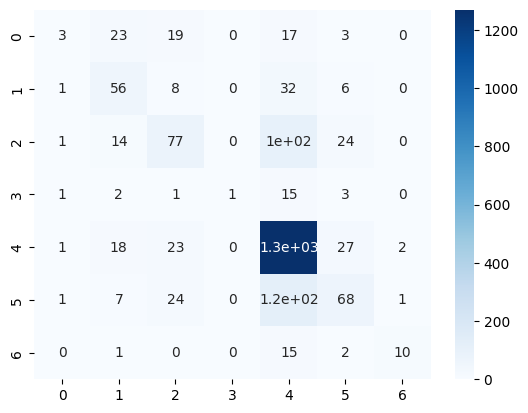

In [24]:
y_pred = np.argmax(model_tl.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()


### Save Model

In [25]:
model_tl.save("skin_cancer_classifier_mobilenet.h5")
